# Analyse GPS data

First part of notebook does analysis for single GPS day, as an example.

Second part runs through multiple days.

For each day of data:

1. Keep only clocks with no missing data points
2. Group clocks into pairs that are at opposite points in orbit
    * Defined such that average separation is > 50,000 km, with < 5% deviation over the day
3. Form the weighted average of all clocks into a single data stream: $\delta\omega/\omega$
4. Calculate amplitude spectrum

Then: Repeat for multiple days of data, have ensemble of spectrums

In [45]:
import AnalyseGPSpairs as gps
import allantools

import numpy as np
from matplotlib import pyplot as plt

## Single day, as example

### Frequncy data
Clock data is GPS (Rb) clock, referenced to ground-based H-maser

In [46]:
# Current satellite configuration:
# Technically changes over time, but stable for considered period
# Also: not required for analysis, just for interest
satellites = np.genfromtxt("current_satellites.txt", dtype=str)
Block = {a: c for a, _, c in satellites}

# Block II, IIA satellites: very old (none currently in use)
# Block IIR - launched from 1997. Still some in operation. Very noisy
# Block IIF - Launched between 2010 and 2016 - good clocks
# Block III - Launched between 2018 and 2023 - good clocks

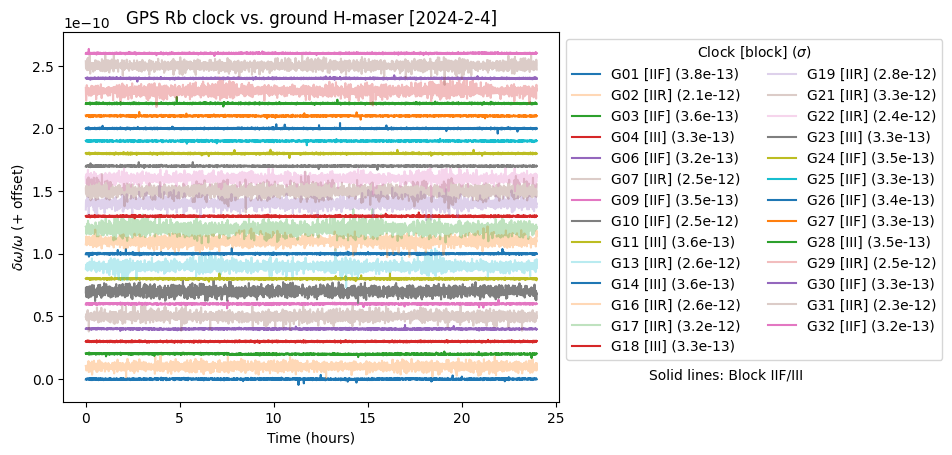

In [47]:
week, day = 2300, 0

# Download the data, if not already downloaded
fname = gps.download_data(week, day)

# Parse the clock data
data, date = gps.get_data(fname)

# Extract frequencies for "good" clocks (no missing data)
good_clocks, dws = gps.get_good_clocks(data)

# Time (in hours), only for plotting:
time = np.linspace(0, 24, gps.num_data_points)

offset = 1e-11
for index, clock in enumerate(good_clocks):
    sigma = np.std(dws[index])
    mean = np.mean(dws[index])
    block = Block[clock]
    # Change opacity depending on old/new satellite (IIR is old)
    opacity = 0.3 if block == "IIR" else 1.0
    plt.plot(
        time,
        dws[index] - mean + index * offset,
        label=f"{clock} [{block}] ({sigma:.1e})",
        alpha=opacity,
    )

plt.title(f"GPS Rb clock vs. ground H-maser [{date}]")
plt.xlabel("Time (hours)")
plt.ylabel("$\\delta\\omega/\\omega$ (+ offset)")
plt.legend(ncols=2, bbox_to_anchor=(1, 1), title="Clock [block] ($\\sigma$)")
plt.text(30, 0.0, "Solid lines: Block IIF/III")
plt.show()

* "Faint" lines are older GPS IIR satellite clocks
* G10 is a IIF clock, but seems to perform poorly, like a IIR clock

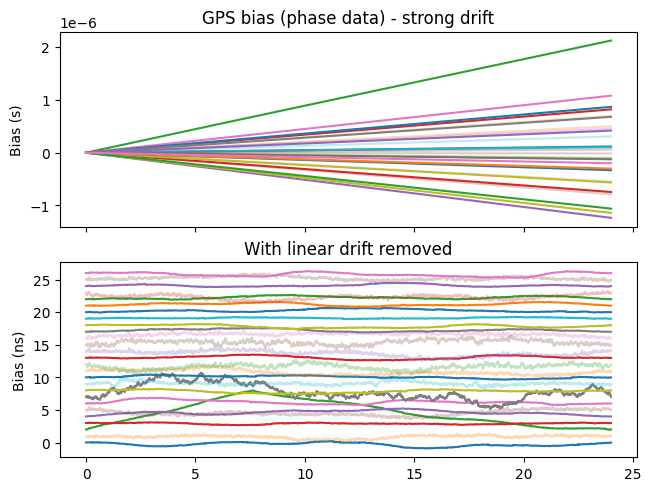

In [92]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout="constrained", sharex=True)

for index, clock in enumerate(good_clocks):
    phase = data[data["PRN"] == clock]["Bias"].to_numpy()[:-1]
    # Begin data on zero
    phase -= phase[0]

    block = Block[clock]
    opacity = 0.3 if block == "IIR" else 1.0

    # Plot raw bias data (shifted to start at 0)
    ax1.plot(time, phase, alpha=opacity)

    # Sabtract off a linear drift (drift in phase, not freq.)
    m = phase[-1] / 24.0
    phase -= time * m
    ax2.plot(time, phase * 1e9 + index, alpha=opacity)


ax1.set_title("GPS bias (phase data) - strong drift")
ax1.set_ylabel("Bias (s)")
ax2.set_title("With linear drift removed")
ax2.set_ylabel("Bias (ns)")
plt.show()

## Let's look closer at G03 - which does something weird
* Weird "step" for week 
* At least we know they don't remove outliers from the data!

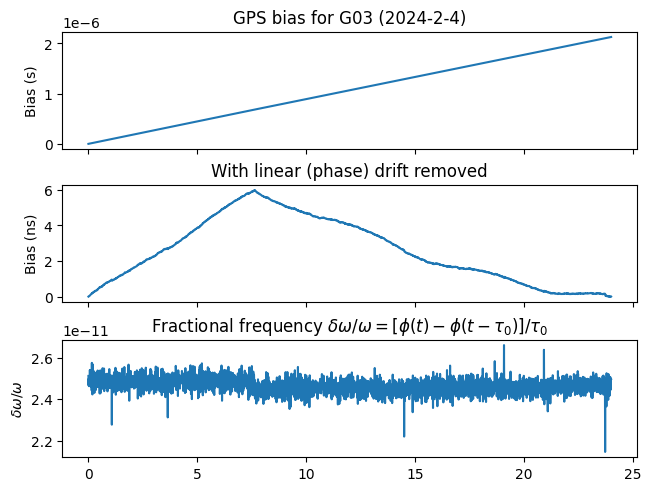

In [112]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, layout="constrained", sharex=True)

for index, clock in enumerate(good_clocks):
    if clock != "G03":
        continue
    phase = data[data["PRN"] == clock]["Bias"].to_numpy()[:-1]
    # Begin data on zero
    phase -= phase[0]

    # Plot raw phase
    ax1.plot(time, phase, label=clock, alpha=opacity)

    # Subtract off a linear drift (drift in phase, not freq.)
    m = phase[-1] / 24.0
    phase -= time * m
    ax2.plot(time, phase * 1e9, label=clock, alpha=opacity)

    # Plot frequency deviations:
    ax3.plot(time, dws[index])


ax1.set_title(f"GPS bias for G03 ({date})")
ax1.set_ylabel("Bias (s)")
ax2.set_title(f"With linear (phase) drift removed")
ax2.set_ylabel("Bias (ns)")
ax3.set_title(
    "Fractional frequency $\\delta\\omega/\\omega = [\\phi(t)-\\phi(t-\\tau_0)]/\\tau_0$"
)
ax3.set_ylabel("$\\delta\\omega/\\omega$")
plt.show()

### Form clock pairs (Rb-Rb) at opposite points in orbit

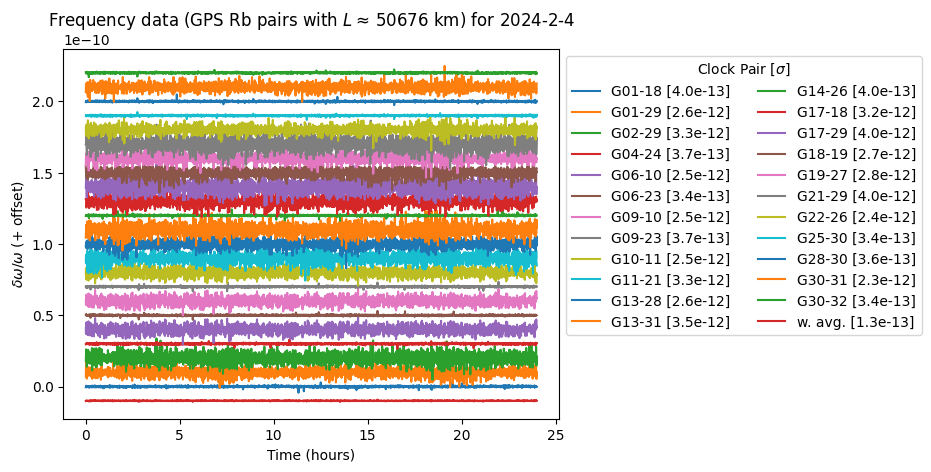

In [113]:
orbits = gps.get_orbits(fname)
good_pairs, avg_distance = gps.form_GPS_pairs(good_clocks, orbits)
avg_distance *= 10000

# Form weighted avgerage of frequency data
dw_avg = gps.form_weighted_average(dws, good_pairs)

for index, [clock_a, clock_b] in enumerate(good_pairs):
    dw_a = dws[clock_a] - np.mean(dws[clock_a])
    dw_b = dws[clock_b] - np.mean(dws[clock_b])
    dw_pair = dw_a - dw_b
    sigma = np.std(dw_pair)
    plt.plot(
        time,
        dw_pair + index * offset,
        label=good_clocks[clock_a] + "-" + good_clocks[clock_b][1:] + f" [{sigma:.1e}]",
    )

sigma_av = np.std(dw_avg)
plt.plot(
    time,
    dw_avg - offset,
    label="w. avg." + f" [{sigma_av:.1e}]",
)

plt.title(
    f"Frequency data (GPS Rb pairs with $L\\approx\\,${avg_distance:.0f} km) for {date}"
)
plt.xlabel("Time (hours)")
plt.ylabel("$\\delta\\omega/\\omega$ (+ offset)")
plt.legend(ncols=2, bbox_to_anchor=(1, 1), title="Clock Pair [$\\sigma$]")
plt.show()

### Plot orbits (distance between clock pairs)

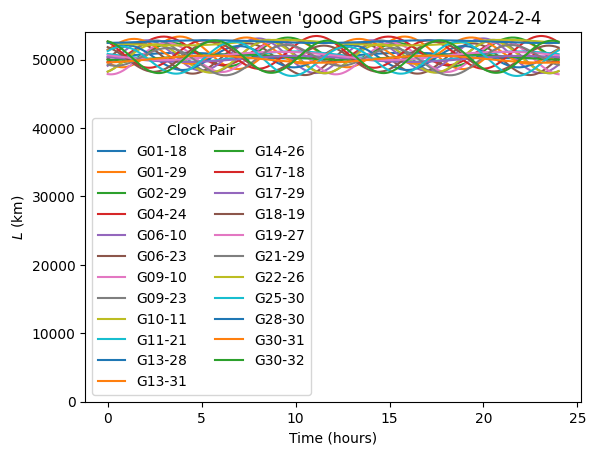

In [114]:
T_orbit, Rs = gps.return_distances(good_pairs, good_clocks, orbits)

for index, [clock_a, clock_b] in enumerate(good_pairs):
    plt.plot(
        T_orbit,
        Rs[index] * 10000,
        label=good_clocks[clock_a] + "-" + good_clocks[clock_b][1:],
    )
plt.title(f"Separation between 'good GPS pairs' for {date}")
plt.xlabel("Time (hours)")
plt.ylabel("$L$ (km)")
plt.ylim(0, 54000)
plt.legend(ncols=2, title="Clock Pair")
plt.show()

### Allan deviations
* Can see clear separation between block III/IIF and older block IIR satellites
* Solid lines is both are modern (III or IIF) satellites, dashed is 1 is, dotted means neither
* Only a guess: calculated using single day of data. In theory could average, but not that useful

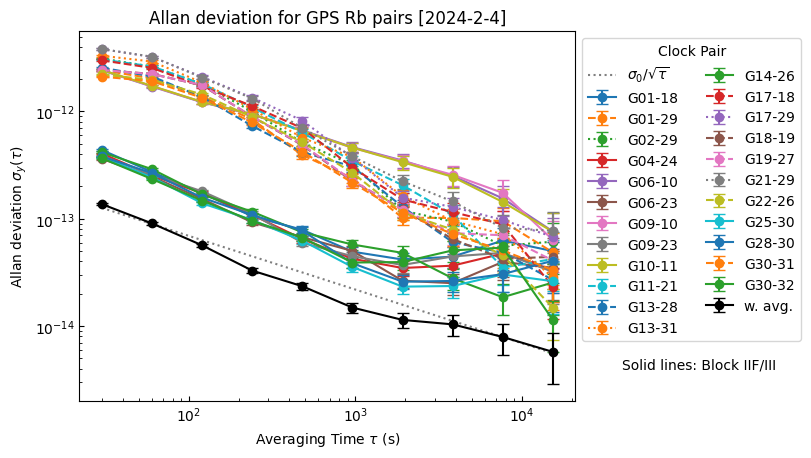

In [115]:
for index, [clock_a, clock_b] in enumerate(good_pairs):

    block_a = Block[good_clocks[clock_a]]
    block_b = Block[good_clocks[clock_b]]

    modern = lambda a: a == "III" or a == "IIF"

    color = (
        "green"
        if modern(block_a) and modern(block_b)
        else "orange" if modern(block_a) or modern(block_b) else "red"
    )

    style = (
        "solid"
        if modern(block_a) and modern(block_b)
        else "dashed" if modern(block_a) or modern(block_b) else "dotted"
    )

    dw_a = dws[clock_a] - np.mean(dws[clock_a])
    dw_b = dws[clock_b] - np.mean(dws[clock_b])
    dw_pair = dw_a - dw_b
    (t1, ad, ade, adn) = allantools.adev(dw_pair, rate=1.0 / gps.tau0, data_type="freq")
    plt.errorbar(
        t1,
        ad,
        yerr=ade,
        marker="o",
        ls=style,
        capsize=4,
        label=good_clocks[clock_a] + "-" + good_clocks[clock_b][1:],
    )

# ADEV of the weighted average
(t1, ad, ade, adn) = allantools.adev(dw_avg, rate=1.0 / gps.tau0, data_type="freq")
plt.errorbar(
    t1,
    ad,
    yerr=ade,
    marker="o",
    color="k",
    capsize=4,
    label="w. avg.",
)

sigma_av = np.std(dw_avg)
plt.plot(
    t1,
    sigma_av * np.sqrt(gps.tau0 / t1),
    ls="dotted",
    c="grey",
    label="$\sigma_0/\\sqrt{\\tau}$",
)

plt.tick_params(direction="in", which="both")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Averaging Time $\\tau$ (s)")
plt.ylabel("Allan deviation $\\sigma_y(\\tau)$")
plt.title(f"Allan deviation for GPS Rb pairs [{date}]")
plt.legend(ncols=2, bbox_to_anchor=(1, 1), title="Clock Pair")
plt.text(4e4, 4e-15, "Solid lines: Block IIF/III")
plt.show()

### And finally, amplitude spectrum:

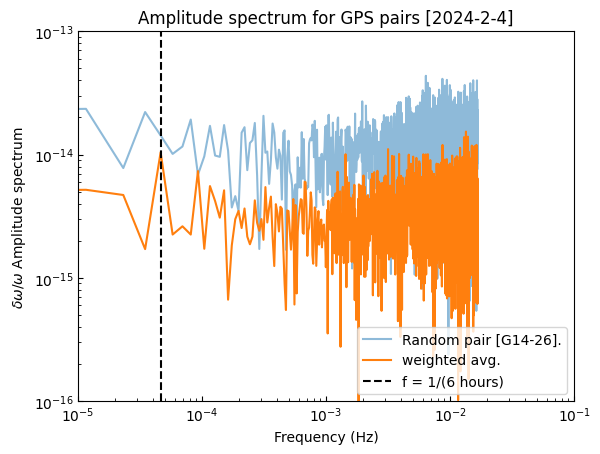

In [116]:
# Amplitude from a single random pair of clocks (for comparison):
clock_a, clock_b = good_pairs[np.random.randint(0, len(good_pairs))]
dw_a = dws[clock_a] - np.mean(dws[clock_a])
dw_b = dws[clock_b] - np.mean(dws[clock_b])
dw_pair = dw_a - dw_b
amp_single = gps.amplitude_spectrum(dw_pair)
plt.plot(
    gps.freq,
    amp_single,
    label=f"Random pair [{good_clocks[clock_a]}-{good_clocks[clock_b][1:]}].",
    alpha=0.5,
)

# Amplitude of weigthed average:
amp_avg = gps.amplitude_spectrum(dw_avg)
plt.plot(gps.freq, amp_avg, label="weighted avg.")


plt.title(f"Amplitude spectrum for GPS pairs [{date}]")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(1e-5, 0.1)
plt.ylim(1e-16, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")

plt.axvline(1 / (6 * 60 * 60), c="k", ls="dashed", label="f = 1/(6 hours)")

plt.legend(loc="lower right")
plt.show()

-------------------
## Part II: Full analysis

* Loop over many days of data
* Calculate spectrum for each day (from weighted average of clock pairs)
* From the set of spectra (1 for each day): get average and standard deviation (for 95% C.L.)
* Write each spectrums to files (1 file per week) - each file contains 7 spectra
    * Simply to avoid re-doing download/parsing
    * Will not re-calculate spectra for a week that's already saved

Note: rather slow: takes time to download the data, and also takes time to read in the large (~6 MB) files

In [117]:
from os import path, mkdir

save_path = "gps-spectrums"
if not path.exists(save_path):
    mkdir(save_path)

# Run for ~30+ weeks [2313 is latest week]
initial_week = 2280
final_week = 2313

for week in range(initial_week, final_week + 1):
    # Download and parse data, if not done already
    out_filename = f"{save_path}/gps-{week}.csv"
    if not path.isfile(out_filename):
        week_amps = []
        print(week, end=": ")
        for day in range(7):
            print(day, end=", ")
            amp, date = gps.calculate_GPS_spectrum(week, day)
            if not len(amp) == 0:
                week_amps.append(amp)
        # Note: this saves each amplitude as a ROW, each frequency as a column
        # don't need full precision
        np.savetxt(f"{save_path}/gps-{week}.csv", week_amps, fmt="%.6e")
        print(f": -> {out_filename}")
    else:
        print(f"Already have: {out_filename}")

Already have: gps-spectrums/gps-2280.csv
Already have: gps-spectrums/gps-2281.csv
Already have: gps-spectrums/gps-2282.csv
Already have: gps-spectrums/gps-2283.csv
Already have: gps-spectrums/gps-2284.csv
Already have: gps-spectrums/gps-2285.csv
Already have: gps-spectrums/gps-2286.csv
Already have: gps-spectrums/gps-2287.csv
Already have: gps-spectrums/gps-2288.csv
Already have: gps-spectrums/gps-2289.csv
Already have: gps-spectrums/gps-2290.csv
Already have: gps-spectrums/gps-2291.csv
Already have: gps-spectrums/gps-2292.csv
Already have: gps-spectrums/gps-2293.csv
Already have: gps-spectrums/gps-2294.csv
Already have: gps-spectrums/gps-2295.csv
Already have: gps-spectrums/gps-2296.csv
Already have: gps-spectrums/gps-2297.csv
Already have: gps-spectrums/gps-2298.csv
Already have: gps-spectrums/gps-2299.csv
Already have: gps-spectrums/gps-2300.csv
Already have: gps-spectrums/gps-2301.csv
Already have: gps-spectrums/gps-2302.csv
Already have: gps-spectrums/gps-2303.csv
Already have: gp

### Read in pre-computed specta

* Average all the spectra 
* I think this is not optimal - doesn't account for the fact that the signal, if it were there, should be always present?

In [118]:
import glob

pre_computed_files = glob.glob(f"{save_path}/gps-*.csv")

# If already calculated, read in from text
amps = []

for file in pre_computed_files:
    week_amps = np.genfromtxt(file)
    for amp in week_amps:
        amps.append(amp)

amp = np.mean(amps, axis=0)
std_dev = np.std(amps, axis=0)
# Should I use standard devition, or standard error for constraint?
std_error = std_dev / np.sqrt(len(amps))

### Plot spectra and threshold
* Threshold based on white-noise result (formula from Melina)
    * Melina's formula was for single pectrum. Since I'm averaging a bunch of spectra, this should probably reduce?
* For confidence level, we use the spread of spectra, since we have 1 spectrum for each day

In [119]:
# detection threshold (based on single day, rather than total average)

fmax = 1 / (2 * 30)  # given by the sampling of 1/30 Hz (Nyquist criterion)
fmin = 1 / (len(dw_avg) * 30)
n_ind = 1 / (fmin) * (fmax - fmin)

# for pure white noise and the given range of sample frequencies there is actually an analytic estimate for the detection threshold
# see https://iopscience.iop.org/article/10.3847/1538-4365/aab766 section 7.4.2
sigma = np.std(dw_avg)
tst = np.sqrt(
    -np.log(1.0 - (1 - 0.05) ** (1.0 / n_ind)) * (sigma) ** 2 * 4 / len(dw_avg)
)

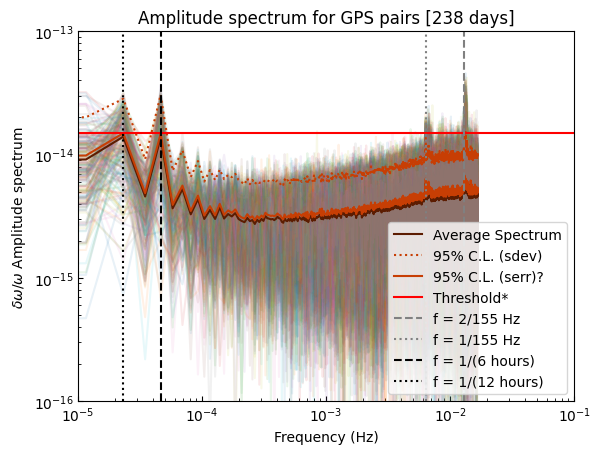

In [121]:
for t_amp in amps:
    plt.plot(gps.freq, t_amp, alpha=0.1)

plt.plot(gps.freq, amp, label="Average Spectrum", c="#5c1c01")
plt.plot(
    gps.freq, amp + 2.0 * std_dev, label="95% C.L. (sdev)", c="#c73e04", ls="dotted"
)
plt.plot(gps.freq, amp + 2.0 * std_error, label="95% C.L. (serr)?", c="#c73e04")
plt.axhline(y=tst, color="r", linestyle="-", label=f"Threshold*")

# Mark some "interesting" features
plt.axvline(2.0 / 155, c="grey", ls="dashed", label="f = 2/155 Hz")
plt.axvline(1 / (155), c="grey", ls="dotted", label="f = 1/155 Hz")
plt.axvline(1 / (6 * 60 * 60), c="k", ls="dashed", label="f = 1/(6 hours)")
plt.axvline(1 / (12 * 60 * 60), c="k", ls="dotted", label="f = 1/(12 hours)")

plt.title(f"Amplitude spectrum for GPS pairs [{len(amps)} days]")
plt.legend(loc="lower right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(1e-5, 0.1)
plt.ylim(1e-16, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")

plt.show()

### Averaged GPS spectrum, compared to cavity data

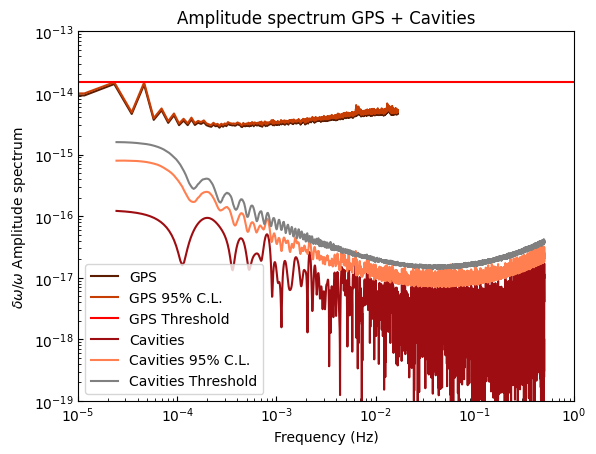

In [122]:
cav = np.genfromtxt("./amplitudespectrum_data.txt")

plt.plot(gps.freq, amp, label="GPS", c="#5c1c01")
# plt.plot(gps.freq, amp + 2.0 * std_dev, label="GPS 95% C.L.", c="#c73e04")
plt.plot(gps.freq, amp + 2.0 * std_error, label="GPS 95% C.L.", c="#c73e04")
plt.axhline(y=tst, color="r", linestyle="-", label=f"GPS Threshold")

plt.plot(cav[1:-1, 0], cav[1:-1, 1], label=f"Cavities", c="#9e0d11")
plt.plot(cav[1:-1, 0], cav[1:-1, 2], label=f"Cavities 95% C.L.", c="coral")
plt.plot(cav[1:-1, 0], cav[1:-1, 3], label=f"Cavities Threshold", c="grey")

plt.title(f"Amplitude spectrum GPS + Cavities")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(1e-5, 1)
plt.ylim(1e-19, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")
plt.show()

### Note

Averageing the spectrums of a large number of days does not improve the results very much.

Maybe that's just how it is, or maybe there's something slightly better we can do?

Strong peaks at 12 and 6 hours: most likely linked to satellite orbit (period is 12 hours)

------------
## Constraints:

In [123]:
def f(m):
    return 2.4e14 * m


def m(f):
    return f / 2.4e14


f_stoch = 3.0
# GPS Diameter
D = 51000


# Previous cavity constraint number (i.e., tempoaral term)
def dOld(A):
    return f_stoch * A * 8.25e16


def dGPS(A):
    # re-scale from previous (1.5 removes n)
    return dOld(A) * (2220 / D) * 1.5


# VERY rough, new cavity result from [just rescale form old formula]
def dCav(A):
    return dOld(A) * (750.0 / 2220) * 1.5 * 4.0 * 1363.0

In [127]:
# Previous limits
hqs = np.genfromtxt("./existing/HQuartzSapphire.txt")
rbq = np.genfromtxt("./existing/RbQuartz.txt")
hsi = np.genfromtxt("./existing/HSi.txt")
ybcs = np.genfromtxt("./existing/YbCs.txt")

# Correct for stochasticity (others already)
hqs[:, 1] = f_stoch * hqs[:, 1]

### Constraints on effective coupling $d_{\rm eff}$
* Any coupling combination that involves $d_{m_e}$

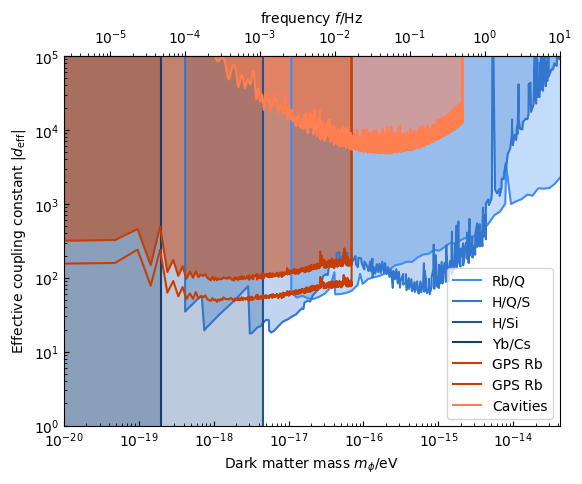

In [128]:
mm = np.append(m(gps.freq), m(gps.freq[-1]))

gps_95cl = amp + 2.0 * std_dev
gps_95cl_2 = amp + 2.0 * std_error  # ?

gps_constraint = np.append(dGPS(gps_95cl), 1e6)
gps_constraint_2 = np.append(dGPS(gps_95cl_2), 1e6)  # ?

fig, ax = plt.subplots()

plt.plot(rbq[:, 0], rbq[:, 1], label="Rb/Q", color="#3d8df5")
plt.fill_between(rbq[:, 0], rbq[:, 1], 1e6, color="#3d8df5", alpha=0.3)

plt.plot(hqs[:, 0], hqs[:, 1], label="H/Q/S", color="#3276cf")
plt.fill_between(hqs[:, 0], hqs[:, 1], 1e6, color="#3276cf", alpha=0.3)

plt.plot(hsi[:, 0], hsi[:, 1], label="H/Si", color="#215291")
plt.fill_between(hsi[:, 0], hsi[:, 1], 1e6, color="#215291", alpha=0.3)

plt.plot(ybcs[:, 0], ybcs[:, 1], label="Yb/Cs", color="#183c6b")
plt.fill_between(ybcs[:, 0], ybcs[:, 1], 1e6, color="#183c6b", alpha=0.3)

plt.plot(mm, gps_constraint, label="GPS Rb", c="#c73e04")
plt.plot(mm, gps_constraint_2, label="GPS Rb", c="#c73e04")
plt.fill_between(mm, gps_constraint, 1e6, color="#c73e04", alpha=0.5)

plt.plot(m(cav[:, 0]), dCav(cav[:, 2]), label="Cavities", c="coral")
plt.fill_between(m(cav[:, 0]), dCav(cav[:, 2]), 1e6, color="coral", alpha=0.5)

plt.xlim(1e-20, m(10.0))
# plt.ylim(1e-4, 1e4)
plt.ylim(1e-0, 1e5)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("")
plt.xlabel("Dark matter mass $m_\\phi/{\\rm eV}$")
plt.ylabel("Effective coupling constant $|d_{\\rm eff}|$")
plt.legend(loc="lower right")
plt.tick_params(direction="in", which="both")


secax = ax.secondary_xaxis("top", functions=(f, m))
secax.set_xlabel("frequency $f/{\\rm Hz}$")

plt.show()

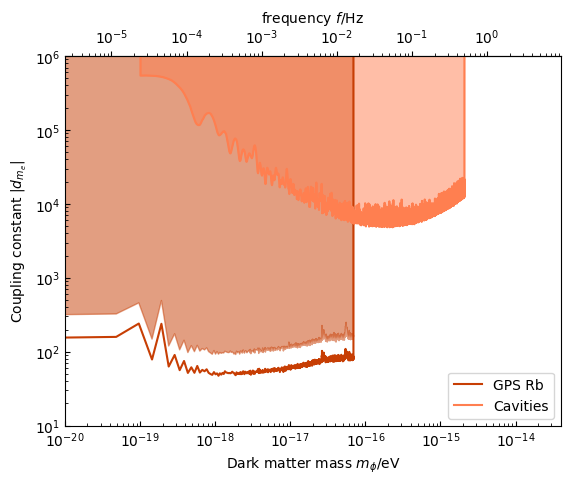

In [129]:
fig, ax = plt.subplots()

plt.plot(mm, gps_constraint_2, label="GPS Rb", c="#c73e04")
plt.fill_between(mm, gps_constraint, 1e6, color="#c73e04", alpha=0.5)

plt.plot(m(cav[:, 0]), dCav(cav[:, 2]), label="Cavities", c="coral")
plt.fill_between(m(cav[:, 0]), dCav(cav[:, 2]), 1e6, color="coral", alpha=0.5)

plt.xlim(1e-20, 4e-14)
# plt.ylim(1e-4, 1e4)
plt.ylim(1e1, 1e6)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("")
plt.xlabel("Dark matter mass $m_\\phi/{\\rm eV}$")
plt.ylabel("Coupling constant $|d_{m_e}|$")
plt.legend(loc="lower right")
plt.tick_params(direction="in", which="both")


secax = ax.secondary_xaxis("top", functions=(f, m))
secax.set_xlabel("frequency $f/{\\rm Hz}$")

plt.show()